<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Training-Stimuli" data-toc-modified-id="Sample-Training-Stimuli-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Training Stimuli</a></span></li><li><span><a href="#Visualize-Conditions" data-toc-modified-id="Visualize-Conditions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualize Conditions</a></span></li><li><span><a href="#Run-Function-Learning-Task" data-toc-modified-id="Run-Function-Learning-Task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Function-Learning Task</a></span></li><li><span><a href="#Save-Simulated-Data" data-toc-modified-id="Save-Simulated-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save Simulated Data</a></span></li><li><span><a href="#Plot-Movements-in-Space" data-toc-modified-id="Plot-Movements-in-Space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot Movements in Space</a></span></li><li><span><a href="#True-y-Value-vs.-Size-of-Change" data-toc-modified-id="True-y-Value-vs.-Size-of-Change-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>True y Value vs. Size of Change</a></span></li><li><span><a href="#Local-Change-vs.-Size-of-Change" data-toc-modified-id="Local-Change-vs.-Size-of-Change-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Local Change vs. Size of Change</a></span></li><li><span><a href="#Prediction-Uncertainty-vs.-Size-of-Change" data-toc-modified-id="Prediction-Uncertainty-vs.-Size-of-Change-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prediction Uncertainty vs. Size of Change</a></span></li><li><span><a href="#Correlations-Between-Movements-in-Different-Conditions" data-toc-modified-id="Correlations-Between-Movements-in-Different-Conditions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Correlations Between Movements in Different Conditions</a></span></li><li><span><a href="#Plot-Changes-in-Uncertainty" data-toc-modified-id="Plot-Changes-in-Uncertainty-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot Changes in Uncertainty</a></span></li></ul></div>

In [1]:
from functools import reduce, partial
from itertools import repeat
from datetime import date
import sys
import multiprocessing
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("..")

In [2]:
# home-grown modules
import py_utils.utils as utils
import py_utils.plotting as plot_utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

In [5]:
plt.style.use("presentation.mplstyle")

In [6]:
dict_variables = dict({
    "condition" : ["smooth", "rough"],
    "prior_sd" : [.5],
    "sampling" : ["improvement"], # "metropolis-hastings", 
    "constrain_space" : [False], # True, 
    "space_edge_min" : [0],
    "space_edge_max" : [12],
    "n_features" : [2],
    "n_training" : [int(12**2/4)],
    "n_runs" : [500]
})

In [7]:
df_info, l_info, l_titles = utils.simulation_conditions(dict_variables)

In [8]:
df_info

,condition,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_runs,length_scale
0,smooth,0.5,improvement,False,0,12,2,36,500,3
1,rough,0.5,improvement,False,0,12,2,36,500,1


# Sample Training Stimuli

In [9]:
make_stimuli_partial = partial(utils.make_stimuli, map_to_reward=True)
l_df_xy = list(map(make_stimuli_partial, l_info))

# Visualize Conditions

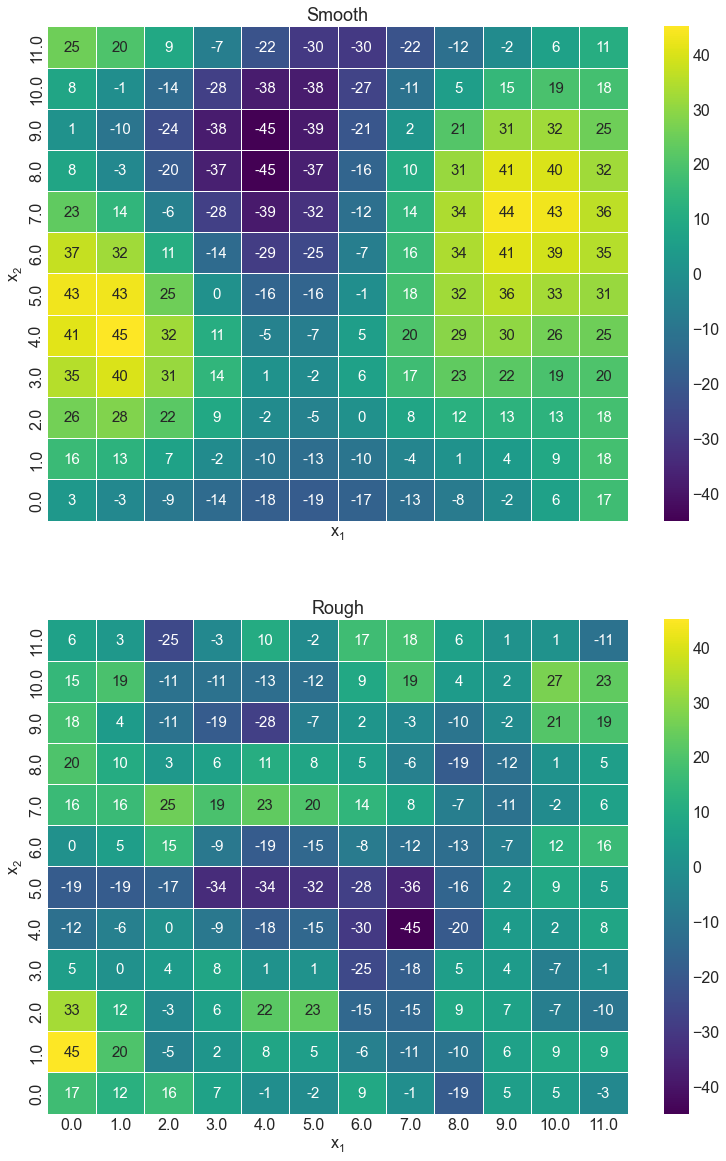

In [10]:
plot_utils.plot_heatmaps(l_info, map_to_reward=True)

C:\Users\MTHALM~1\AppData\Local\Temp/ipykernel_2676/53579342.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


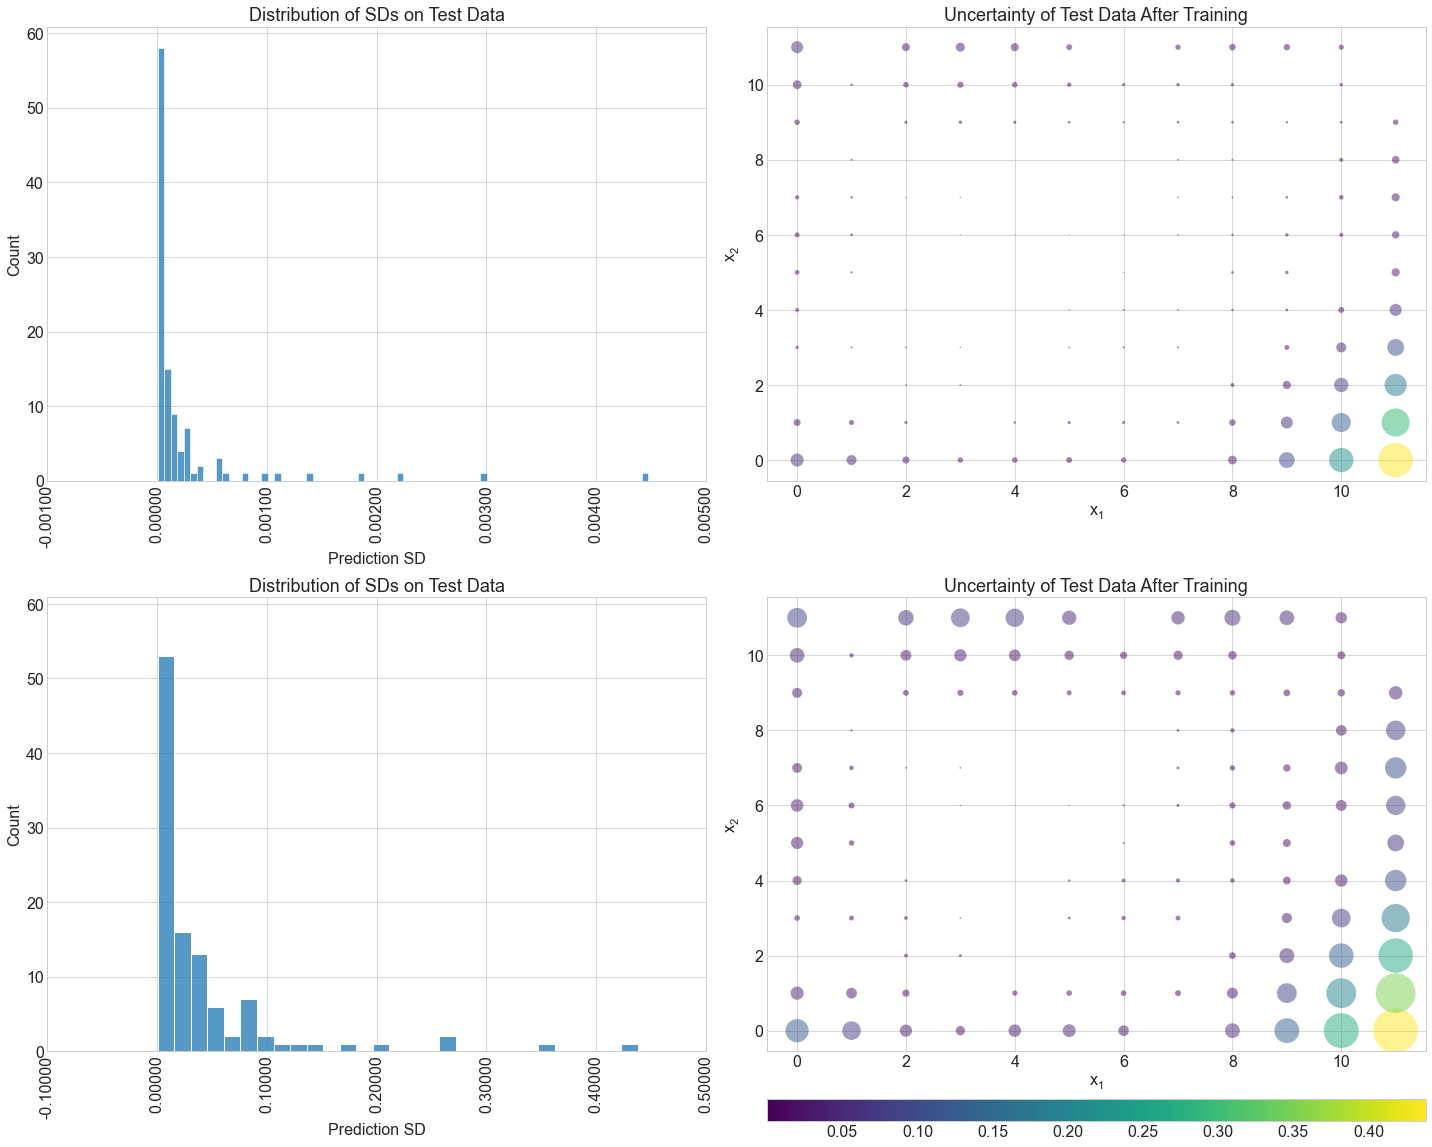

In [11]:
float_formatter = "{:.5f}".format
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20, 16), sharex=False, sharey="col",
                  gridspec_kw={"height_ratios":[1, 1]})
axes_flat = axes.flatten()
l_df_xy[0], l_ivs, scaler = utils.scale_ivs(l_df_xy[0])
l_df_xy[1], l_ivs, scaler = utils.scale_ivs(l_df_xy[1])
df_train1, df_test1 = utils.split_train_test(l_info[0], l_df_xy[0])
df_train2, df_test2 = utils.split_train_test(l_info[1], l_df_xy[1])
# smooth
df_test1 = plot_utils.uncertainty_on_test_data(
    df_train1, df_test1, l_info[0], l_ivs
)
# rough
df_test2 = plot_utils.uncertainty_on_test_data(
    df_train2, df_test2, l_info[1], l_ivs
)
min_val = min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min())
max_val = max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())

plot_utils.plot_uncertainty_on_test_data(df_test1, axes_flat[0:2], show_colorbar=False, min_val=min_val, max_val=max_val)
plot_utils.plot_uncertainty_on_test_data(df_test2, axes_flat[2:4], show_colorbar=False, min_val=min_val, max_val=max_val)


norm = plt.Normalize(
    min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min()), 
    max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
axins = inset_axes(axes_flat[3],
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-7
                   )
_ = fig.colorbar(sm, cax=axins, orientation="horizontal")
l_df_xy[0].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)
l_df_xy[1].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)

xt0 = [float_formatter(t) for t in axes_flat[0].get_xticks()]
axes_flat[0].xaxis.set_ticks([float(xv) for xv in xt0])
axes_flat[0].set_xticklabels(xt0, rotation=90)
xt2 = [float_formatter(t) for t in axes_flat[2].get_xticks()]
axes_flat[2].xaxis.set_ticks([float(xv) for xv in xt2])
_ = axes_flat[2].set_xticklabels(xt2, rotation=90)

plt.tight_layout()

*TO CONSIDERs*
- proportion of datapoints shown to participants during training (currently .25)

Metropolis-Hastings Implementation
1. compare the deviation on the current trial to the distribution of expected deviations from y_pred_sd
2. uniformly sample a value between 0 and 1
3. accept the sample if that value is smaller than the ratio in 1.

## Possibilities
- Fit Length Scale on Train Data
    - yes / no
- Fit Length Scale After Sample Has Been Accepted
    - yes / no
    
## Notes
- If length scale is not fit, prediction accuracy depends on proportion of train data
- if length scale is not fit after training data have been seen, how can this be thought of cognitively? where would people know the true length scale from? this seems to be implausible


# Run Function-Learning Task

In [12]:
n_cpus = min(len(l_info), multiprocessing.cpu_count() - 2)
p = multiprocessing.Pool(n_cpus)
#f_partial = partial(utils.run_perception, l_df_xy=l_df_xy)
# multiprocessing Pool map does not accept partial functions
list_perception = []
for x in tqdm(p.starmap(utils.run_perception_pairs, zip(l_info, l_df_xy))):
    list_perception.append(x)

  0%|          | 0/2 [00:00<?, ?it/s]

In [61]:
list_dfs_new = [l[0] for l in list_perception]
list_gps = [l[1] for l in list_perception]
list_scalers = [l[2] for l in list_perception]

In [90]:
def predict_on_block(n_block, df, scaler, m_gp, df_info, seed1, seed2, perceive):
    df_l = utils.perceive_block_stim(df, n_block, scaler, df_info.loc[0, "prior_sd"], seed1, perceive=perceive)
    df_l["y_pred"] = m_gp.predict(df_l[["x_1_z", "x_2_z"]])
    df_r = utils.perceive_block_stim(df, n_block, scaler, df_info.loc[0, "prior_sd"], seed2, perceive=perceive)
    df_r["y_pred"] = m_gp.predict(df_r[["x_1_z", "x_2_z"]])
    l_vars = ["stim_id", "y_pred", "y"]
    df_decide = pd.concat([df_l[l_vars], df_r[l_vars]], axis=1)
    df_decide.columns = ["stim_id_l", "y_pred_l", "y_l", "stim_id_r", "y_pred_r", "y_r"]
    df_decide = pd.concat([df_l[l_vars], df_r[l_vars]], axis=1)
    df_decide.columns = ["stim_id_l", "y_pred_l", "y_l", "stim_id_r", "y_pred_r", "y_r"]
    df_decide.eval("y_pred_diff = y_pred_r - y_pred_l", inplace=True)
    df_decide.query("stim_id_l != stim_id_r").reset_index(inplace=True)
    df_decide = df_decide.loc[0:(n_block - 1), ]
    return df_decide.head()

In [91]:
predict_on_block(200, list_dfs_new[0], list_scalers[0], list_gps[0], df_info, 1265, 9983, perceive="sample")

,stim_id_l,y_pred_l,y_l,stim_id_r,y_pred_r,y_r,y_pred_diff
0,97,0.485175,-3.0,98,-19.588161,-20.0,-20.073336
1,46,19.136167,19.0,73,26.323357,32.0,7.187190
2,54,-2.320769,5.0,107,32.302844,32.0,34.623613
3,92,32.879780,34.0,54,3.921661,5.0,-28.958119
4,1,5.510912,-3.0,12,19.527496,16.0,14.016584


In [87]:
predict_on_block(200, list_dfs_new[0], list_scalers[0], list_gps[0], df_info, 1265, 9983, perceive="fixed")

,stim_id_l,y_pred_l,y_l,stim_id_r,y_pred_r,y_r,y_pred_diff
0,97,1.613969,-3.0,98,-18.150199,-20.0,-19.764168
1,46,19.859501,19.0,73,28.388122,32.0,8.528621
2,54,4.365583,5.0,107,33.748155,32.0,29.382572
3,92,33.910003,34.0,54,4.365583,5.0,-29.544420
4,1,-3.533571,-3.0,12,11.616263,16.0,15.149833


In [93]:
df_decide_perceived = predict_on_block(
    200, list_dfs_new[0], list_scalers[0], list_gps[0], df_info, 1265, 9983, perceive="prior"
)
df_decide_fixed = predict_on_block(
    200, list_dfs_new[0], list_scalers[0], list_gps[0], df_info, 1265, 9983, perceive="fixed"
)

In [92]:
def logistic(x, y_diff_pred, y_r, y_l):
    beta0 = x[0]
    beta1 = x[1]
    l = beta0 + beta1 * y_diff_pred
    prob = 1/(1 + np.exp(-l))
    val_sum = (prob * y_r + (1 - prob) * y_l).sum()
    return -val_sum

In [96]:
logistic_partial = partial(
    logistic, y_diff_pred=df_decide_perceived["y_pred_diff"], y_r=df_decide_perceived["y_r"], y_l=df_decide_perceived["y_l"]
)
minimize(logistic_partial, [0, 1])

      fun: -110.99999866266383
 hess_inv: array([[  95.30340187,  678.26543451],
       [ 678.26543451, 4879.33937681]])
      jac: array([-9.53674316e-07, -9.53674316e-06])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([0.16895116, 2.2151675 ])

In [97]:
logistic_partial = partial(
    logistic, y_diff_pred=df_decide_fixed["y_pred_diff"], y_r=df_decide_fixed["y_r"], y_l=df_decide_fixed["y_l"]
)
minimize(logistic_partial, [0, 1])

      fun: -110.99999886461687
 hess_inv: array([[  55.55551173,  465.59643282],
       [ 465.59643282, 3974.5679482 ]])
      jac: array([-9.53674316e-07, -9.53674316e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([0.10467643, 1.89348527])

*TODOs*
- add option mapping y vals to reward vals in make_stimuli function
- predict whether< left or right value is chosen (true value to be chosen is true difference between y left and y right)
- sum up all rewards received during the trials

In [ ]:
df_info["first_l"] = [k[0] for k in list_kernels]
df_info["final_l"] = [k[-1] for k in list_kernels]
df_length = df_info.groupby(["condition", "prior_sd", "sampling"])[["first_l", "final_l"]].mean().reset_index()
df_length = df_length.melt(
    id_vars=["condition", "prior_sd", "sampling"], 
    value_vars=["first_l", "final_l"],
    var_name="Timepoint",
    value_name="Length Value"
)
_ = sns.catplot(
    x="Timepoint", y="Length Value", hue="condition", 
    row="sampling", col="prior_sd", kind="point", scale=5,
    data=df_length
)

# Save Simulated Data

In [ ]:
str_today = str(date.today())

with open(f"""../data/{str_today}-dont-refit-gp.pickle""", "wb") as f:
    pickle.dump(list_dfs_new, f)

In [ ]:
with open("../data/2021-11-15-dont-refit-gp-1000-samples.pickle", "rb") as f:
    list_dfs_new = pickle.load(f)

- think about leaving in prior points when plotting movements (prior & likelihood...) as I did that in the category learning part

# Plot Movements in Space

In [ ]:
f_partial = partial(plot_utils.plot_moves_one_condition, list_dfs_new=list_dfs_new, df_info=df_info)
l_idxs = df_info.index[4:8].to_list()
f, axes = plt.subplots(1, 4, figsize=(30, 8))
_ = list(map(f_partial, l_idxs, axes.flatten()))
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-smooth-movements-refit.png""")

In [ ]:
f_partial = partial(plot_utils.plot_moves_one_condition, list_dfs_new=list_dfs_new, df_info=df_info)
l_idxs = df_info.index[12:16].to_list()
f, axes = plt.subplots(1, 4, figsize=(30, 8))
_ = list(map(f_partial, l_idxs, axes.flatten()))
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-rough-movements-refit.png""")

# True y Value vs. Size of Change

In [ ]:
list_dfs_new = list(map(utils.add_max_gradient, tqdm(list_dfs_new)))

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_y, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()

# Local Change vs. Size of Change

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_max_gradient, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()

# Prediction Uncertainty vs. Size of Change

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_start_uncertainty, list_dfs_new, l_titles, axes_flat))
plt.tight_layout()
str_note = "Note. y axes differ between panels"
_ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)

# Correlations Between Movements in Different Conditions

In [ ]:
l_df_movements = list(map(utils.add_angle_of_movements, list_dfs_new))

In [ ]:
def correlation_between_movement_angles(idx1: int, idx2:int, l_df_movements: list) -> float:
    df_tmp = pd.merge(l_df_movements[idx1], l_df_movements[idx2], how="inner", left_index=True, right_index=True)
    return np.corrcoef(df_tmp["angle_x"], df_tmp["angle_y"])[0, 1]

In [ ]:
df1 = pd.Series(range(len(l_df_movements)), name="Condition 1")
df2 = pd.Series(range(len(l_df_movements)), name="Condition 2")
df_cross = pd.merge(df1, df2, how="cross")
f_partial = partial(correlation_between_movement_angles, l_df_movements = l_df_movements)
df_cross["correlation"] = list(map(f_partial, df_cross["Condition 1"].to_list(), df_cross["Condition 2"].to_list()))

In [ ]:
filt_info = (df_info["constrain_space"] == False)#(df_info["prior_sd"] == 1)# & 
idxs_required = df_info.loc[filt_info].index.to_list()#
filt = (df_cross["Condition 1"].isin(idxs_required)) & (df_cross["Condition 2"].isin(idxs_required))
df_cross = df_cross.loc[filt, ].copy()

In [ ]:
df_cross["corr_above_0"] = df_cross["correlation"] > 0
prop_above_0 = (
    df_cross.query("`Condition 1` != `Condition 2`")["corr_above_0"].sum() / 
    df_cross.query("`Condition 1` != `Condition 2`").shape[0]
).round(2)
print("Proportion of Correlations > 0 between Movement Directions in Simulation Conditions: ", prop_above_0)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    df_cross.pivot(index="Condition 1", columns="Condition 2", values="correlation").round(2), 
    annot=True, annot_kws={"size":15}, linewidths=1, cmap="vlag", vmin = -1, vmax = 1, ax=ax
)
_ = ax.set_title("Pairwise Correlations Between Movement Directions in Simulation Conditions")
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-pairwise-correlations-constrained-refit.png""")

# Plot Changes in Uncertainty

In [ ]:
stim_id = 133 # but then 132 shows opposite pattern
l_idxs = [2, 6, 10, 14]
#l_idxs = [0, 4, 8, 12]
#l_idxs = [i + 1 for i in l_idxs]
l_idxs = range(0, 16)
n_plots = len(l_idxs)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
f, axes = plt.subplots(n_cols, n_rows, figsize=(n_cols*7, n_rows*4), sharex="col", sharey="col")
plot_utils.plot_gp_deviations(axes, l_idxs, list_dfs_new, l_titles) # , stim_id
plt.suptitle("Model Deviation from True Points after Testing Period\n", size=20)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(25, 18), sharex=True, sharey=True)
f_partial = partial(plot_utils.plot_proportion_accepted_samples, n_runs=l_info[0]["n_runs"])
list(map(f_partial, list_dfs_new, l_titles, axes.flatten()))
_ = fig.suptitle("Proportion of Accepeted Samples Over Course of Function-Learning Task\n")
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(25, 18), sharex=True, sharey=False)
list(map(plot_utils.plot_uncertainty_over_test, list_dfs_new, l_titles, axes.flatten()))
_ = fig.suptitle("Uncertainty of Predictions Against Test Trial\n")
plt.tight_layout()
str_note = "Note. y axes differ between panels"
_ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)